In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/test.csv (1)/test.csv')
train = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/train.csv (1)/train.csv')
sample = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/sample (1).csv')
movie = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews-term-break1/movies.csv (1)/movies.csv')

<font size='5'>importing libraries

In [2]:
import numpy as np
from pprint import pprint
np.random.seed(42)
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate,RandomizedSearchCV,cross_val_predict
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier, RidgeClassifier,LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train.describe()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
count,162758,162758,162758,156311,162758
unique,16812,4482,2,155071,2
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review,POSITIVE
freq,708,962,113189,29,108761


In [4]:
movie.info()
movie.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23001 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


,audienceScore,runtimeMinutes
count,73248.000000,129431.000000
mean,55.674967,93.708578
std,24.553648,28.129175
min,0.000000,1.000000
25%,37.000000,84.000000
50%,57.000000,92.000000
75%,76.000000,103.000000
max,100.000000,2700.000000


In [5]:
movie=movie.drop_duplicates(subset="movieid")
merge=pd.merge(train,movie,on="movieid",how="left")

In [6]:
merge1=pd.merge(test,movie,on="movieid",how="left")

<font size='5'>checking for the null values

In [7]:
merge.isnull().sum()

movieid                     0
reviewerName                0
isFrequentReviewer          0
reviewText               6447
sentiment                   0
title                       0
audienceScore           13248
rating                  63724
ratingContents          63724
releaseDateTheaters     35834
releaseDateStreaming    16185
runtimeMinutes           3376
genre                    2438
originalLanguage         3290
director                    0
boxOffice               52776
distributor             40663
soundType               85367
dtype: int64

<font size='5'>frequency of sentiment

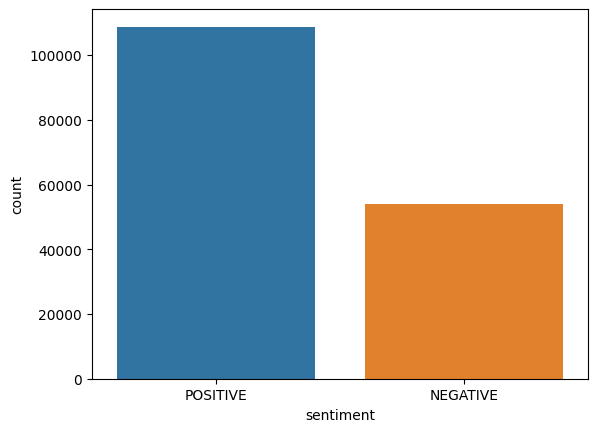

In [8]:
sns.countplot(x='sentiment', data= train)  # Visualize the distribution of the target variable
plt.show()

**we can see that frequency of positive sentiment is more than that of negative sentiment**

<font size='5'>mean audience score by reviewer frequency

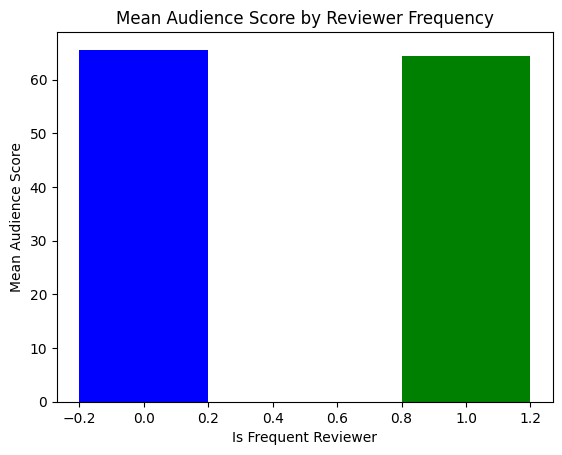

In [9]:
mean_scores = merge.groupby('isFrequentReviewer')['audienceScore'].mean()
plt.bar(mean_scores.index, mean_scores.values, color=['blue', 'green'],width=0.4)
plt.title('Mean Audience Score by Reviewer Frequency')
plt.xlabel('Is Frequent Reviewer')
plt.ylabel('Mean Audience Score')
plt.show()

**we grouped the isfrequentreviewer and found the mean of audience score**

<font size='5'>mean audience score by sentiment

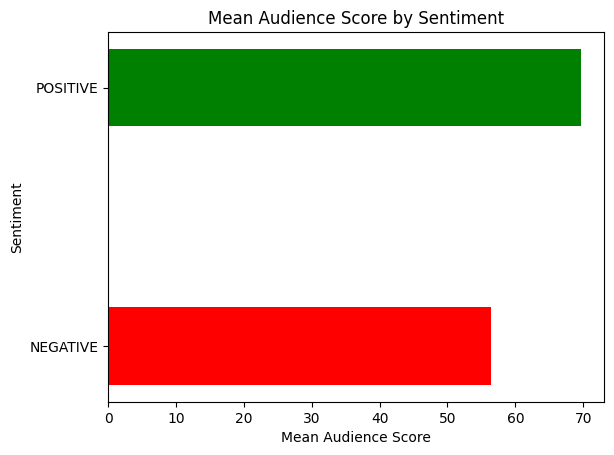

In [10]:
mean_scores = merge.groupby('sentiment')['audienceScore'].mean()
plt.barh(mean_scores.index, mean_scores.values, color=['Red', 'Green'],height=0.3)
plt.title('Mean Audience Score by Sentiment')
plt.ylabel('Sentiment')
plt.xlabel('Mean Audience Score')
plt.show()

**we grouped the sentiment and calculated the mean audiencescore**

<font size='5'>mean runtime by sentiment

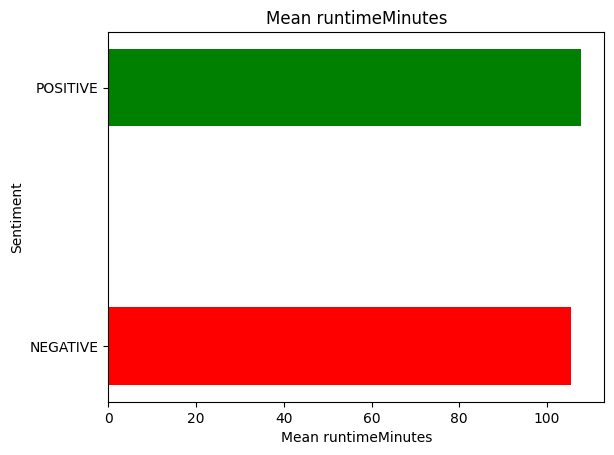

In [11]:
mean_scores = merge.groupby('sentiment')['runtimeMinutes'].mean()
plt.barh(mean_scores.index, mean_scores.values, color=['Red', 'Green'],height=0.3)
plt.title('Mean runtimeMinutes')
plt.ylabel('Sentiment')
plt.xlabel('Mean runtimeMinutes')
plt.show()

**we grouped the sentiment and calculated the mean of runtime minutes**

<font size='4'>heatmap
to find correlation between audience score, runtime, is frequent reviewer and sentiment

In [12]:
'''import seaborn as sns
from sklearn.preprocessing import LabelEncoder
feature_columns =list(merge.columns)
target_variable = 'sentiment'
le=LabelEncoder()
merge["sentiment"]=le.fit_transform(merge["sentiment"])
correlations = merge[feature_columns].corr(method='pearson')
plt.figure(figsize=(5,5))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation between features and target variable')
plt.show()'''

'import seaborn as sns\nfrom sklearn.preprocessing import LabelEncoder\nfeature_columns =list(merge.columns)\ntarget_variable = \'sentiment\'\nle=LabelEncoder()\nmerge["sentiment"]=le.fit_transform(merge["sentiment"])\ncorrelations = merge[feature_columns].corr(method=\'pearson\')\nplt.figure(figsize=(5,5))\nsns.heatmap(correlations, annot=True, cmap=\'coolwarm\')\nplt.title(\'Correlation between features and target variable\')\nplt.show()'

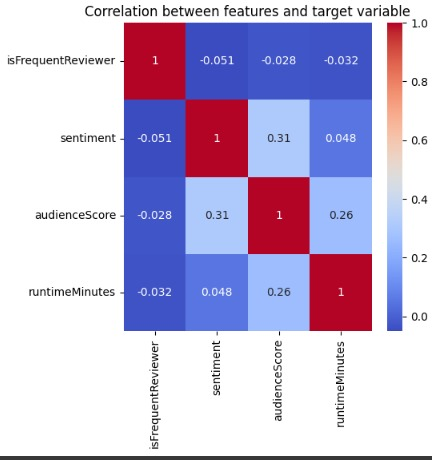

**we can see that sentiment has moderately strong correlation with audience score and weak correlation with runtime minutes and negative correlation with isfrequentReviewer**

<font size="6">boxplot to find outlier</font>

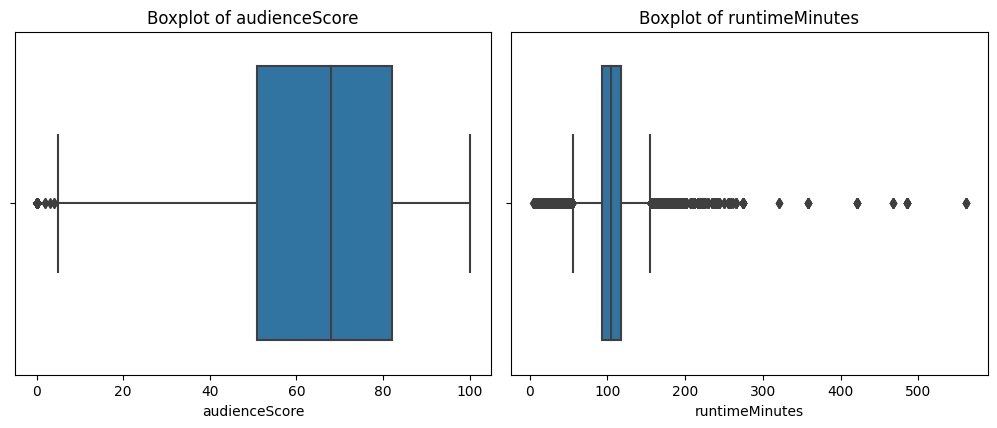

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
numeric_features = ['audienceScore','runtimeMinutes']
for i, feature in enumerate(numeric_features):
    sns.boxplot(x=merge[feature], ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f"Boxplot of {feature}")

if i < 19:
    for j in range(i+1, 20):
        fig.delaxes(axes[j//4, j%4])
plt.tight_layout()

# Show the plot
plt.show()

**we can see that audience score doesn't have much outliers but run time minutes has many outliers.** 

<font size='5'>taking only review text, audience score, runtime

In [14]:
train_data= merge[['reviewText', 'audienceScore','runtimeMinutes']]  # Select columns 'A' and 'C'
train_data=pd.DataFrame(train_data,columns=['reviewText', 'audienceScore','runtimeMinutes'])

**we took 3 columns from merge and converted them into dataframe**

<font size='5'>filling the missing review with empty string

In [15]:
train_data["reviewText"]=train_data["reviewText"].fillna("")

<font size='5'>column transformer

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
numeric_features=['audienceScore','runtimeMinutes']
cat_features='reviewText'

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="mean")),
    ('scalar',StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("countvectorizer", CountVectorizer())
])


# Use ColumnTransformer to apply the different preprocessing steps to the appropriate columns
preprocessor = ColumnTransformer(
      transformers=[
           ('cat', categorical_transformer, cat_features),
           ('num', numeric_transformer, numeric_features),
      ])

**we used simple imputer to fill the missing values using strategy mean and used standard scaler for scaling**

In [17]:
y = merge['sentiment']

**we took the sentiment column from merge and stored it in y**

In [18]:
X = preprocessor.fit_transform(train_data)

<font size='5'>logistic regression

In [19]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
model=lr.fit(X,y)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**prediction**

In [20]:
y_pred=model.predict(X)
print(classification_report(y ,y_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.82      0.74      0.78     53997
    POSITIVE       0.88      0.92      0.90    108761

    accuracy                           0.86    162758
   macro avg       0.85      0.83      0.84    162758
weighted avg       0.86      0.86      0.86    162758



<font size='5'>MLP Classifier

In [21]:
'''from sklearn.neural_network import MLPClassifier

# Create model object
clf = MLPClassifier(hidden_layer_sizes=(6,5),
                    random_state=5,
                    verbose=True,
                    learning_rate_init=0.01,
                    tol=0.01)

# Fit data onto the model
clf.fit(X,y)'''

'from sklearn.neural_network import MLPClassifier\n\n# Create model object\nclf = MLPClassifier(hidden_layer_sizes=(6,5),\n                    random_state=5,\n                    verbose=True,\n                    learning_rate_init=0.01,\n                    tol=0.01)\n\n# Fit data onto the model\nclf.fit(X,y)'

In [22]:
'''y_pred=clf.predict(X)
print(classification_report(y ,y_pred))'''

'y_pred=clf.predict(X)\nprint(classification_report(y ,y_pred))'

<font size='5'>Gradient Boosting Classifier

In [23]:
#from sklearn.ensemble import GradientBoostingClassifier as gbc
#model=gbc()

#model.fit(X,y)

In [24]:
#y_pred=model.predict(X)
#print(classification_report(y ,y_pred))

In [25]:
test_data= merge1[['reviewText', 'audienceScore','runtimeMinutes']]  # Select columns 'A' and 'C'
test_data=pd.DataFrame(test_data,columns=['reviewText', 'audienceScore','runtimeMinutes'])

**took the 3 columns from merge1 and then converted them to dataframe**

In [26]:
test_data['reviewText'] = test_data['reviewText'].fillna(' ')
test_pre = preprocessor.transform(test_data)

In [27]:
prediction = model.predict(test_pre)

In [28]:
# Apply label encoding to the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(prediction)

**used label encoding to convert positive and negative values to 0 and 1**

In [29]:
y_pred = label_encoder.inverse_transform(y_encoded)

**we again converted them back to positive and negative values**

In [30]:
y_pred.shape

(55315,)

In [31]:
# Create the output DataFrame and save it as a CSV file
output_data = pd.DataFrame({'id': range(len(y_pred)), 'sentiment': y_pred})
output_data.to_csv('submission.csv', index=False)

In [32]:
#submission_df.head()

<font size='4'> conclusion-we can see that even though the accuracy of MLPClassifier is more our best model is logistic regression since MLPClassifier was overfitting the model